# Correlations and linear models
A linear model estimate a response from the linear combination of one or more inputs

$y \approx x_1 \alpha_1 + y_2 \alpha_2 + ... + y_n \alpha_n$

$y \approx \vec{x} \cdot \vec{\alpha}$

given an estimation $\hat{y} = \vec{x} \cdot \vec{\alpha}$

we look for the best $\vec{\alpha}$ which minimize all residuals $\epsilon(\hat{y}) = y - \hat{y}$

In [137]:
import pandas as pd

This dataset collects the yearly water and energy consuption estimation per capita in Milan collected by the italian government

Data is grouped by 

- water consumption
- methan consumption
- electricity consumption

In [138]:
cons = pd.read_csv("ds523_consumoacquaenergia.csv",sep=";")

In [139]:
cons.describe(include="all")

,anno,Consumo pro capite tipo,Consumo pro capite
count,36.00000,36,36.000000
unique,NaN,3,NaN
top,NaN,Energia elettrica per uso domestico,NaN
freq,NaN,12,NaN
mean,2005.50000,NaN,573.072222
std,3.50102,NaN,471.777743
min,2000.00000,NaN,80.400000
25%,2002.75000,NaN,89.625000
50%,2005.50000,NaN,432.900000
75%,2008.25000,NaN,1195.650000


In [140]:
cons["Consumo pro capite tipo"].unique()

array(['Energia elettrica per uso domestico',
       'Gas metano per uso domestico e riscaldamento',
       'Acqua fatturata per uso domestico'], dtype=object)

In [141]:
translate = {
    'Energia elettrica per uso domestico':'electricity',
    'Gas metano per uso domestico e riscaldamento':'methan',
    'Acqua fatturata per uso domestico':'water'
}
cons["type"] = cons["Consumo pro capite tipo"].map(translate)

In [142]:
cons2 = cons.pivot(index="anno",columns="type",values="Consumo pro capite").reset_index()
cons2 = cons2.rename({"anno":"year"}, axis="columns")
cons2

type,year,electricity,methan,water
0,2000,1130.2,509.0,92.1
1,2001,1143.9,500.7,91.3
2,2002,1195.5,504.2,90.4
3,2003,1222.8,480.2,87.3
4,2004,1228.6,442.4,80.4
5,2005,1225.0,434.5,81.3
6,2006,1219.7,431.3,82.2
7,2007,1197.0,381.1,81.6
8,2008,1203.0,384.9,84.5
9,2009,1202.9,389.6,85.8


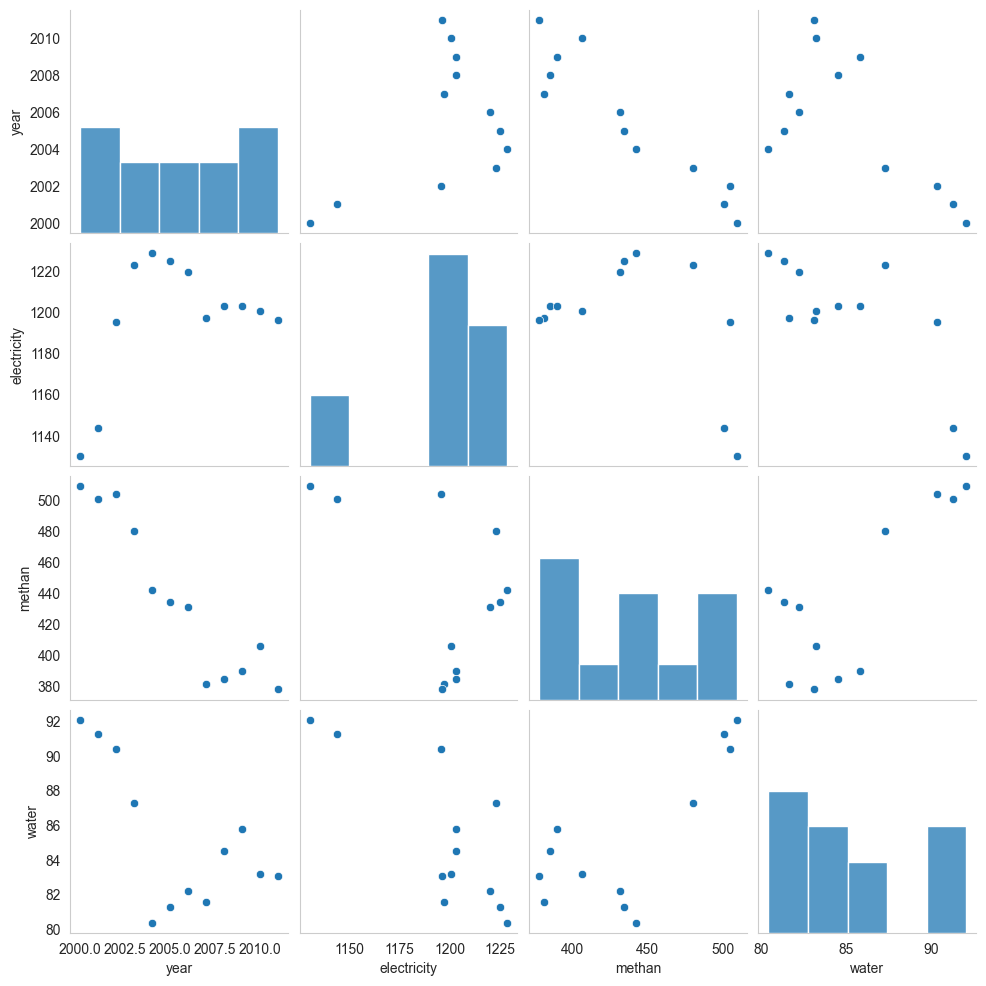

In [143]:
import seaborn as sns
sns.pairplot(cons2)

<Axes: xlabel='year', ylabel='methan'>

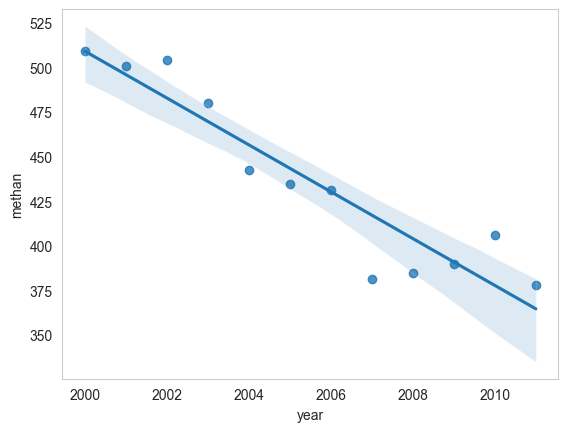

In [144]:
sns.regplot(cons2,x="year",y="methan")

## Covariance and correlation

The [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix), defined as

$cov[X_i, X_j] = E[(X_i - E[X_i])(X_j - E[X_j])]$

is the multidimensional extension of the variance, elements of the diagonal being the variance of the corrisponding dimension; its eigenvectors define an ellipsoid representing the most important combinations of the dimensional features; this is used in [Principal Compaonent Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), a technique which helps to define the most impactful features.

By dividing each element with the product of the standard deviations we have the [correlation matrix](https://en.wikipedia.org/wiki/Correlation)

$corr[X_i, X_j] = \frac{E[(X_i - E[X_i])(X_j - E[X_j])]}{\sigma_i\sigma_j}$

The elements outside the diagonal are numbers between -1 and 1; 0 represents no correlation (like a spherical cloud) while 1 and -1 represent positive and negative correlation respectively; this gives us a first estimation of the possible linear dependecies within a set of observation features; 

In [145]:
import numpy as np
# numpy expects a matrix where each feature is in a row instead of a column
# thus we need to transpose it
np.corrcoef(np.transpose(np.array(cons2)))

array([[ 1.        ,  0.44786015, -0.93548315, -0.65540971],
       [ 0.44786015,  1.        , -0.46029677, -0.77514369],
       [-0.93548315, -0.46029677,  1.        ,  0.75208366],
       [-0.65540971, -0.77514369,  0.75208366,  1.        ]])

we can see that the negative correlation between year and methan is about -0.9 which makes it a good candidate for a linear correlation

In [146]:
from scipy import stats

## Regression calculation
in this simple case we have 
- few observations
- only one input value
so we may directly use the [Ordinary Least Squares regression method](https://en.wikipedia.org/wiki/Ordinary_least_squares) to evaluate the best fit

In [147]:
result = stats.linregress(x=cons2.year, y=cons2.methan)
result

LinregressResult(slope=np.float64(-13.141258741258738), intercept=np.float64(26791.62773892773), rvalue=np.float64(-0.9354831530794605), pvalue=np.float64(7.894692952340763e-06), stderr=np.float64(1.5697563928623894), intercept_stderr=np.float64(3148.151109622701))

the returned object contains some interesting values; let's check the first two:
- slope
- intercept
  
allows us to write a simple prediction formula

In [148]:
def predict_methan(year):
    return result.slope * year + result.intercept


with this formula we can build a chart of our linear regression

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

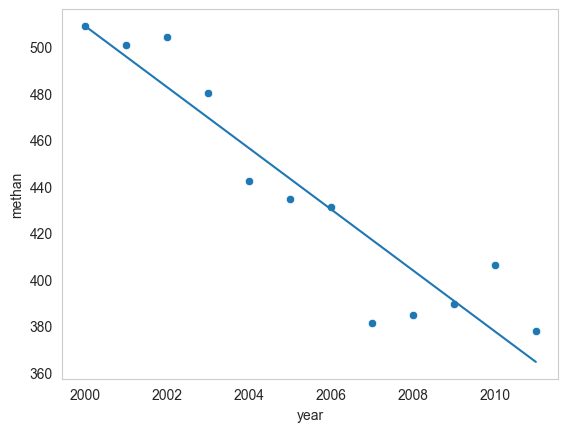

In [150]:
# create a plot canvas
fig, ax = plt.subplots(1,1)

#first plot the points into our canvas
sns.scatterplot(x=cons2.year, y=cons2.methan, ax=ax)

# then plot a line from the first to the last point on the same canvas
year0 = min(cons2.year)
year1 = max(cons2.year)
ax.plot((year0,year1),(predict_methan(year0),predict_methan(year1)))

note: the polymorphism allows to properly use the prodict_methan function also with pandas Series

## Assessing the qaulity of a regression

In [151]:
residuals = cons2.methan - predict_methan(cons2.year)

looking at residuals distribution may show some pattern; in this case we may assume there is a better way to represent the relation between the features under investigation.

In our example looks like there is no apparent pattern

Text(0, 0.5, 'residuals')

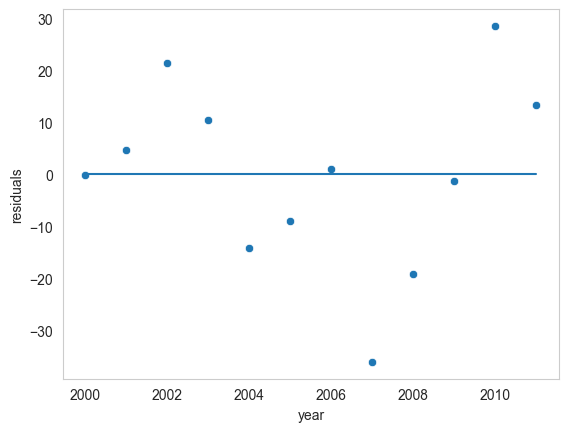

In [153]:
ax = sns.scatterplot(x=cons2.year, y=residuals)
ax.plot((year0,year1),(0,0))
ax.set_ylabel("residuals")

The next step would be to assess the variance of residuals respect to the total variance of the distribution of the output variable Y:

\begin{equation}
\frac{var[\epsilon]}{var[Y]} = \frac{E[(\epsilon - E[\epsilon])^2]}{E[(Y - E[Y])^2]}
\end{equation}

let's use $\hat{Y}$ to represent the predicted values;
by knowing that the mean of the residuals is 0 and their definition 

\begin{equation}
E[\epsilon] = 0
\end{equation}

\begin{equation}
\epsilon = Y - \hat{Y}
\end{equation}

we have

\begin{equation}
\frac{var[\epsilon]}{var[Y]} = \frac{E[(Y - \hat{Y})^2]}{E[(Y - E[Y])^2]}
\end{equation}

now the quantity

\begin{equation}
R^2 = 1 - \frac{E[(Y - \hat{Y})^2]}{E[(Y - E[Y])^2]}
\end{equation}

represent the fraction of the variance of the original dataset explained by the linear relation: this is a real number between 0 and 1 where 0 represents no actual explaination (i.e. the mean has the same prediction power) to 1 representing all the relation is explained

## Multiple input parameters
in order to perform this regression with multiple inputs we are going to use the ```statmodels``` library (see [documentation](https://www.statsmodels.org/stable/index.html))

Execute the following cell only the first time

In [ ]:
!pip install statsmodels

In [9]:
import statsmodels as sm
from statsmodels.api import formula as smf
import requests
import pandas as pd

We will use a crime dataset from UCLA

In [31]:
headers = "crimerat maleteen south educ police60 police59 labor  males pop nonwhite unemp1  unemp2 median belowmed".split()
crime = pd.read_csv(
    "https://stats.idre.ucla.edu/wp-content/uploads/2016/02/crime.txt",
    sep=r"\s+",
    names=headers,
    dtype=float
)

This is the description of the content of this table
|Columns | meaning|
|--------|--------|
|CrimeRat| Crime rate: # of offenses reported to police per million population
|MaleTeen| The number of males of age 14-24 per 1000 population
|South   | Indicator variable for Southern states (0 = No, 1 = Yes)
|Educ    | Mean # of years of schooling for persons of age 25 or older
|Police60| 1960 per capita expenditure on police by state and local government
|Police59| 1959 per capita expenditure on police by state and local government
|Labor   | Labor force participation rate per 1000 civilian urban males age 14-24
|Males   | The number of males per 1000 females
|Pop     | State population size in hundred thousands
|NonWhite| The number of non-whites per 1000 population
|Unemp1  | Unemployment rate of urban males per 1000 of age 14-24
|Unemp2  | Unemployment rate of urban males per 1000 of age 35-39
|Median  | Median value of transferable goods and assets or family income in tens of $
|BelowMed| The number of families per 1000 earning below 1/2 the median income



In [24]:
crime.head()

,crimerat,maleteen,south,educ,police60,police59,labor,males,pop,nonwhite,unemp1,unemp2,median,belowmed
0,79.1,151.0,1.0,9.1,58.0,56.0,510.0,950.0,33.0,301.0,108.0,41.0,394.0,261.0
1,163.5,143.0,0.0,11.3,103.0,95.0,583.0,1012.0,13.0,102.0,96.0,36.0,557.0,194.0
2,57.8,142.0,1.0,8.9,45.0,44.0,533.0,969.0,18.0,219.0,94.0,33.0,318.0,250.0
3,196.9,136.0,0.0,12.1,149.0,141.0,577.0,994.0,157.0,80.0,102.0,39.0,673.0,167.0
4,123.4,141.0,0.0,12.1,109.0,101.0,591.0,985.0,18.0,30.0,91.0,20.0,578.0,174.0


The ```south``` feature is actually categorical and cannot be treated in the same way as others but let's pretend it is not different for this exercise

In [130]:
crime.describe()

,crimerat,maleteen,south,educ,police60,police59,labor,males,pop,nonwhite,unemp1,unemp2,median,belowmed
count,47.000000,47.000000,47.000000,47.00000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,90.508511,138.574468,0.340426,10.56383,85.000000,80.234043,561.191489,983.021277,36.617021,101.127660,95.468085,33.978723,525.382979,194.000000
std,38.676270,12.567634,0.478975,1.11870,29.718974,27.961319,40.411814,29.467365,38.071188,102.828819,18.028783,8.445450,96.490944,39.896061
min,34.200000,119.000000,0.000000,8.70000,45.000000,41.000000,480.000000,934.000000,3.000000,2.000000,70.000000,20.000000,288.000000,126.000000
25%,65.850000,130.000000,0.000000,9.75000,62.500000,58.500000,530.500000,964.500000,10.000000,24.000000,80.500000,27.500000,459.500000,165.500000
50%,83.100000,136.000000,0.000000,10.80000,78.000000,73.000000,560.000000,977.000000,25.000000,76.000000,92.000000,34.000000,537.000000,176.000000
75%,105.750000,146.000000,1.000000,11.45000,104.500000,97.000000,593.000000,992.000000,41.500000,132.500000,104.000000,38.500000,591.500000,227.500000
max,199.300000,177.000000,1.000000,12.20000,166.000000,157.000000,641.000000,1071.000000,168.000000,423.000000,142.000000,58.000000,689.000000,276.000000


Note that there are some very skewed distributions like the non white which has a very large standard deviation respect to the mean; this value also shows a long queue according to the percentiles.

Moreover, due to their definitions some features have very different ranges.

This may have an impact in evaluating the eigenvectors as some dimensions may appear as more relevant then others due to their scale.

For these reasons we may expect that renormalizing all distributions respect to their standard deviation may change our findings.

### Evaluating correlations and covariance

In [131]:
import numpy as np
crime_array = np.transpose(np.array(crime))
covariance = np.cov(crime_array)
correlation = np.corrcoef(crime_array)
pd.DataFrame({"correlation":correlation[0,1:],"features":headers[1:]})

,correlation,features
0,-0.089472,maleteen
1,-0.090637,south
2,0.322835,educ
3,0.687604,police60
4,0.666714,police59
5,0.188866,labor
6,0.213914,males
7,0.337474,pop
8,0.032599,nonwhite
9,-0.050478,unemp1


apparently the crime rate most relevant correlation seems to be the increase in police expenditure which may probably be more a consequence than a causation

In [134]:
from numpy.linalg._linalg import EigResult
# eigenvectors will be returned already sorted from the most to the least relevant
result :EigResult = np.linalg.eig(covariance)

def relevant(headers: [str], result: EigResult, rank: int):
    """retruns the features of the rank-th eigenvalue sorted from the largest descending"""
    # extract the rank-th eigenvector
    vector = result.eigenvectors[:,rank] 
    # square it to get rid of sign
    vector_sq = vector * vector
    # get the order from smallest to largest
    order = vector_sq.argsort()
    # reverse order and return the features from the most relevant
    return [headers[int(i)] for i in reversed(order)]

let's grab the 5 most relevant set of features

In [66]:
for i in range(5):
    print(relevant(headers, result, i))

['nonwhite', 'median', 'belowmed', 'police60', 'police59', 'labor', 'crimerat', 'maleteen', 'males', 'pop', 'unemp1', 'educ', 'south', 'unemp2']
['nonwhite', 'median', 'crimerat', 'pop', 'police60', 'police59', 'males', 'belowmed', 'labor', 'unemp1', 'unemp2', 'maleteen', 'south', 'educ']
['labor', 'males', 'pop', 'crimerat', 'nonwhite', 'belowmed', 'maleteen', 'unemp2', 'unemp1', 'police59', 'educ', 'police60', 'median', 'south']
['pop', 'crimerat', 'median', 'belowmed', 'nonwhite', 'labor', 'police60', 'police59', 'males', 'unemp1', 'unemp2', 'maleteen', 'educ', 'south']
['labor', 'crimerat', 'pop', 'males', 'unemp1', 'unemp2', 'belowmed', 'police60', 'nonwhite', 'police59', 'median', 'maleteen', 'south', 'educ']


### Performing regression from multiple inputs

In the following multilinear correlation we construct a formula representing the features which may impact to the expected output

```
output ~ feature1 + feature2 + feature3
```

I chose to use all of the features which appear as most relevant in the first eigenvector and appear before our output

In [135]:
formula = "crimerat ~ "+ (" + ".join(relevant(headers, result, 0)[:6]))
print(formula)
model = smf.ols(formula,crime)
regression = model.fit()
regression.summary()

crimerat ~ nonwhite + median + belowmed + police60 + police59 + labor


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               crimerat   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     11.75
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           1.48e-07
Time:                        21:48:11   Log-Likelihood:                -214.10
No. Observations:                  47   AIC:                             442.2
Df Residuals:                      40   BIC:                             455.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -304.9695     96.968     -3.145      0.003    -500.950    -108.989
nonwhite       0.0050      0.056      0.088      0.930      -0.109       0.119
median         0.1588      0.112      1.419      0.164      -0.067       0.385
belowmed       0.6875      0.223      3.085      0.004       0.237       1.138
police60       1.3928      1.140      1.222      0.229      -0.910       3.696
police59      -0.3685      1.239     -0.297      0.768      -2.872       2.135
labor          0.1592      0.100      1.594      0.119      -0.043       0.361
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                1.581
Skew:                          -0.436   Prob(JB):                        0.454
Kurtosis:                       3.220   Cond. No.                     2.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The result of the fit method which is shown here above displays a wealth of information; most notably
- some quality evaluation of the regression e.g. $R^2$
- all the evaluated parameters and the intercept

### Exploring features
it is also important to not blindly accept the result of a regression without a further analysis of the dataset

In [90]:
import matplotlib.pyplot as mpl
import seaborn as sns

In the following code I will check how the output variable depends on the features we examined; as this plot does not really show the interdipendence of all features some images may be difficult to interpret

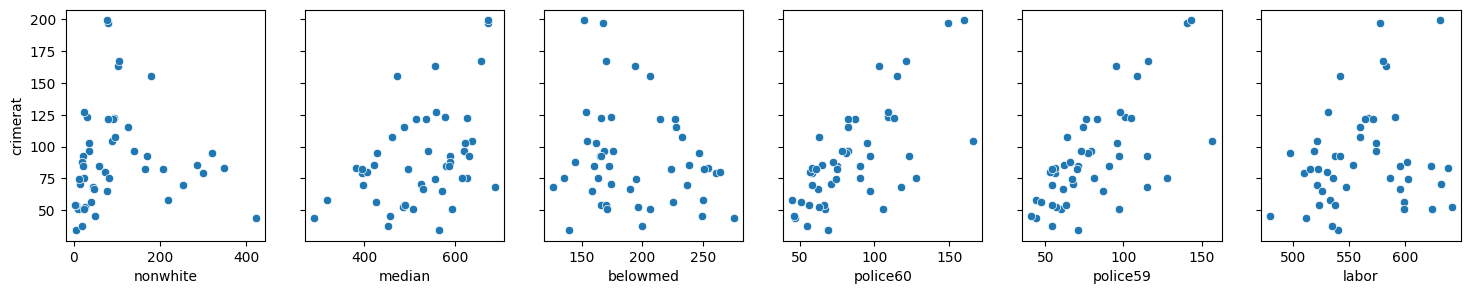

In [100]:
fig, axs = mpl.subplots(1,6,sharey=True,figsize=(18,3))
features = relevant(headers, result, 0)[:6]
for i in range(6):
    sns.scatterplot(x=crime[features[i]],y=crime.crimerat,ax=axs[i])

### Correcting eigenvector bias with correlation matrix
by using the correlation instead of the covariance, the range of all features is normalized now between -1 and 1

As we can see the most interesting eigenvectors change 

In [104]:
result2 = np.linalg.eig(correlation)

In [105]:
for i in range(5):
    print(relevant(headers, result2, i))

['median', 'belowmed', 'educ', 'police59', 'police60', 'south', 'maleteen', 'nonwhite', 'crimerat', 'labor', 'males', 'pop', 'unemp1', 'unemp2']
['pop', 'labor', 'unemp2', 'males', 'police60', 'police59', 'nonwhite', 'crimerat', 'south', 'educ', 'median', 'belowmed', 'unemp1', 'maleteen']
['unemp1', 'unemp2', 'labor', 'maleteen', 'crimerat', 'males', 'nonwhite', 'police59', 'police60', 'pop', 'south', 'educ', 'belowmed', 'median']
['males', 'crimerat', 'maleteen', 'labor', 'nonwhite', 'belowmed', 'unemp1', 'pop', 'south', 'unemp2', 'police60', 'police59', 'educ', 'median']
['pop', 'labor', 'belowmed', 'south', 'maleteen', 'police59', 'median', 'police60', 'unemp2', 'educ', 'unemp1', 'nonwhite', 'crimerat', 'males']


In [107]:
rank_no = 0
features_count = 8
formula = "crimerat ~ "+ (" + ".join(relevant(headers, result2, rank_no)[:features_count]))
print(formula)
model = smf.ols(formula,crime)
regression = model.fit()
regression.summary()

crimerat ~ median + belowmed + educ + police59 + police60 + south + maleteen + nonwhite


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               crimerat   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     12.82
Date:                Sat, 04 Jan 2025   Prob (F-statistic):           1.02e-08
Time:                        21:27:44   Log-Likelihood:                -207.24
No. Observations:                  47   AIC:                             432.5
Df Residuals:                      38   BIC:                             449.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -537.5940    108.276     -4.965      0.000    -756.786    -318.402
median         0.1764      0.101      1.740      0.090      -0.029       0.382
belowmed       0.8438      0.211      3.994      0.000       0.416       1.271
educ          14.4615      5.068      2.853      0.007       4.201      24.722
police59      -0.8715      1.099     -0.793      0.433      -3.096       1.353
police60       1.8952      1.015      1.868      0.069      -0.159       3.949
south         -1.9020     12.426     -0.153      0.879     -27.057      23.253
maleteen       0.9286      0.379      2.451      0.019       0.161       1.696
nonwhite      -0.0025      0.060     -0.041      0.967      -0.124       0.119
==============================================================================
Omnibus:                        0.285   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.010
Skew:                          -0.016   Prob(JB):                        0.995
Kurtosis:                       3.064   Cond. No.                     2.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interestingly this correlation shows a better $R^2$ than the previous one thus demonstrating the effectiveness of using normalized distributions

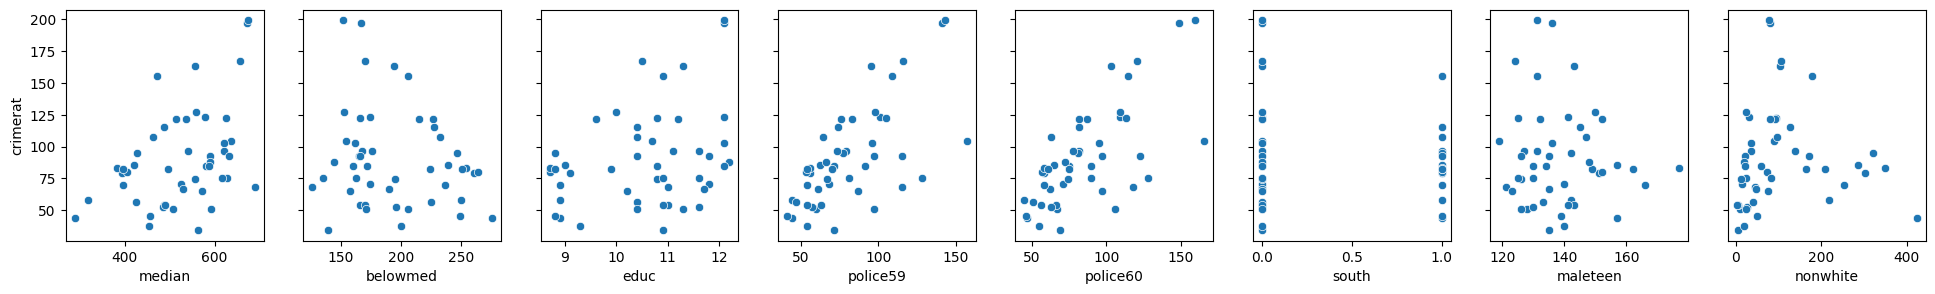

In [106]:
rank_no = 0
features_count = 8
fig, axs = mpl.subplots(1,features_count,sharey=True,figsize=(features_count * 3,3))
features = relevant(headers, result2, 0)[:features_count]
for i in range(features_count):
    sns.scatterplot(x=crime[features[i]],y=crime.crimerat,ax=axs[i])

### More visualization of the correlations
in the following examples I will show a couple of scatter plots of the most relevant features and use colors for the output variable; while this visualization does not add a great insight, nonetheless can raise interesting questions about the mutual connections of the features

<Axes: xlabel='belowmed', ylabel='median'>

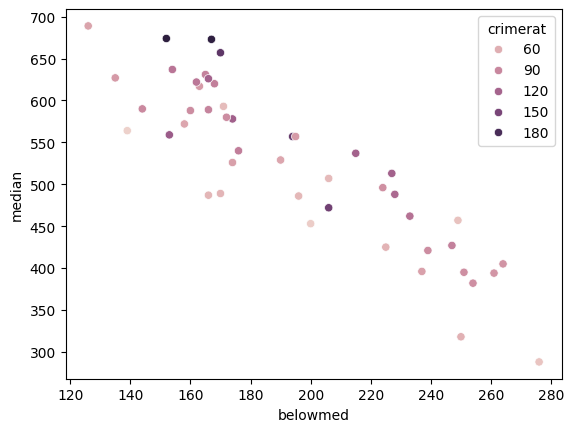

In [116]:
sns.scatterplot(x=crime.belowmed,y=crime["median"],hue=crime.crimerat)

This image shows that some of the highest crime rate seems to show in an area where economic indicators seems more favorable, which just demonstrates how complex and controversial this analysis may be: deciding which features to include may have important consequences.

A 3d version of the same plot adding the education feature

<Axes3D: xlabel='belowmed', ylabel='median', zlabel='educ'>

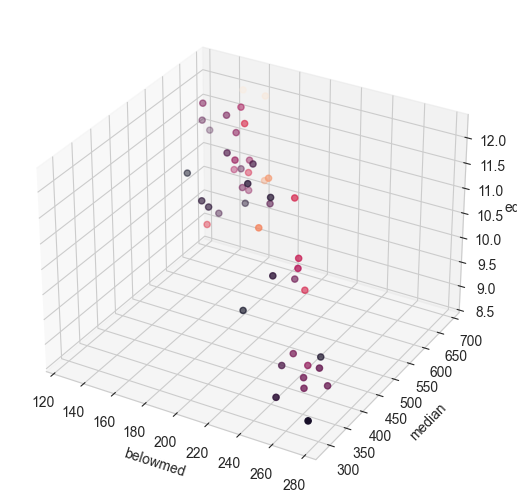

In [125]:
#sns.scatterplot(x=crime.belowmed,y=crime["median"],hue=crime.crimerat)
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure()

ax = Axes3D(fig) 
fig.add_axes(ax)
x=crime.belowmed
y=crime["median"]
z=crime.educ

ax.scatter(x, y, z, c=crime.crimerat, marker='o')
ax.set_xlabel('belowmed')
ax.set_ylabel('median')
ax.set_zlabel('educ')
ax

## Non-Linear features
the linearity of linear models is defined by the interaction between different features but this may be used in with non linear cases e.g. trying to fit a polynomial model